In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Running SPARQL queries

[SPARQL](https://www.w3.org/TR/rdf-sparql-query/) is a standard query language for RDF.
Note: there are also other approaches for queries, such [SHACL](https://www.w3.org/TR/shacl/) the *Shapes Constraint Language*.

In any case, if you've worked with SQL queries before, SPARQL should seem quite familiar.

OH: 
>"If you build it, they will SPARQL"

First, let's define a small graph in RDF:

In [2]:
ttl_text = """
@prefix : <http://www.w3.org/2012/12/rdf-val/SOTA-ex#> .
@prefix foaf: <http://xmlns.com/foaf/0.1/'> .

:peep0 a foaf:Person ;
    foaf:givenName "Alice" ;
    foaf:familyName "Nakamoto" ;
    foaf:phone <tel:+1.555.222.2222> ;
    foaf:mbox <mailto:alice@example.org> .

:peep1 a foaf:Person ;
    foaf:givenName "Bob" ;
    foaf:familyName "Patel" ;
    foaf:phone <tel:+1.555.666.5150> ;
    foaf:mbox <mailto:bob@example.org> .

:peep2 a foaf:Person ;
    foaf:givenName "Dhanya" ;
    foaf:familyName "O'Neill" ;
    foaf:phone <tel:+1.555.123.9876> ;
    foaf:mbox <mailto:dhanya@example.org> .
"""

Then construct a graph using `rdflib`:

In [3]:
from icecream import ic
import rdflib

g = rdflib.Graph()
g.parse(data=ttl_text, format="ttl")

<Graph identifier=N8613f4b28e184f42ad6e9be08ef8b29b (<class 'rdflib.graph.Graph'>)>

Now we'll define a SPARQL query to extract the surnames and email addresses for each person in the graph, in descending order by surname:

In [4]:
sparql = """
    SELECT ?person ?surname ?email
    WHERE {
        ?person foaf:familyName ?surname .
        ?person foaf:mbox ?email .
    }
    ORDER BY DESC(?surname)
"""

Then run the SPARQL query and iterate over its result set:

In [5]:
for row in g.query(sparql):
    ic(row.asdict())

ic| row.asdict(): {'email': rdflib.term.URIRef('mailto:bob@example.org'),
                   'person': rdflib.term.URIRef('http://www.w3.org/2012/12/rdf-val/SOTA-ex#peep1'),
                   'surname': rdflib.term.Literal('Patel')}
ic| row.asdict(): {'email': rdflib.term.URIRef('mailto:dhanya@example.org'),
                   'person': rdflib.term.URIRef('http://www.w3.org/2012/12/rdf-val/SOTA-ex#peep2'),
                   'surname': rdflib.term.Literal("O'Neill")}
ic| row.asdict(): {'email': rdflib.term.URIRef('mailto:alice@example.org'),
                   'person': rdflib.term.URIRef('http://www.w3.org/2012/12/rdf-val/SOTA-ex#peep0'),
                   'surname': rdflib.term.Literal('Nakamoto')}


To access the URLs and literals from those results in more readable form, use the `n3()` function with the graph's namespaces to extract formatted text from each term:

In [6]:
for row in g.query(sparql):
    person = row["person"].n3(g.namespace_manager)
    surname = eval(row["surname"].n3())
    email = row["email"].n3()

    ic(person, surname, email)

ic| person: ':peep1'
    surname: 'Patel'
    email: '<mailto:bob@example.org>'
ic| person: ':peep2'
    surname: "O'Neill"
    email: '<mailto:dhanya@example.org>'
ic| person: ':peep0'
    surname: 'Nakamoto'
    email: '<mailto:alice@example.org>'


---

## SPARQL queries with `kglab` abstractions

Now we'll load our medium size KG from the previous example.
Note that an additional namespace with the `nom:` prefix gets added at this point.
We'll use that in the following examples:

In [7]:
import kglab

namespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = namespaces,
    )

kg.load_rdf("tmp.ttl")

## Identify recipes with special ingredients

Let's define a query based on [SPARQL 1.1](https://www.w3.org/TR/sparql11-query/) to look for recipes that use *eggs*:

In [8]:
sparql = """
SELECT ?recipe ?definition ?time
  WHERE {
      ?recipe rdf:type wtm:Recipe .
      ?recipe skos:definition ?definition .
      ?recipe wtm:hasIngredient ind:ChickenEgg .
      ?recipe wtm:hasCookTime ?time
  }
  ORDER BY DESC(?time)
  """

Now we'll run the query and iterate through its result set:

In [9]:
import pandas as pd
pd.set_option("max_rows", None)

df = kg.query_as_df(sparql)
df.head(20)

,recipe,definition,time
0,<https://www.food.com/recipe/64564>,classic cooked eggnog,1 days 00:30:00
1,<https://www.food.com/recipe/16163>,safe eggnog,0 days 12:15:00
2,<https://www.food.com/recipe/43126>,mrs corbins butter cookies,0 days 06:15:00
3,<https://www.food.com/recipe/284530>,rooster cookies sugar cookies,0 days 04:10:00
4,<https://www.food.com/recipe/31041>,marti s homemade noodles,0 days 02:40:00
5,<https://www.food.com/recipe/124106>,hungarian noodles homemade,0 days 02:00:00
6,<https://www.food.com/recipe/144841>,2 step pound cake for a kitchen aide mixer,0 days 01:50:00
7,<https://www.food.com/recipe/483334>,wallis crepes,0 days 01:40:00
8,<https://www.food.com/recipe/371915>,crepes alton brown,0 days 01:40:00
9,<https://www.food.com/recipe/272433>,fannie farmer s pound cake,0 days 01:35:00


That's interesting – notice the outliers based on cooking times, i.e., recipes for *eggnog* or special kinds of *cookies* and *noodles*. Some of these take hours or even days to prepare.

## Using SPARQL queries and post-processing to create annotations

Let's begin to add [*annotations*](https://www.w3.org/TR/annotation-model/) to the KG.
In other words, we'll add descriptions to the recipes to help classify them based on an [*ontology*](https://www.datasciencecentral.com/profiles/blogs/understanding-how-taxonomies-differ-from-ontologies).

We've created a brief *controlled vocabulary* in RDF called `NOM` in the `dat/nom.ttl` file, which provides part of a simple taxonomy for our recipes.
Take a look at those definitions – mostly these are distinctions between two kind of flour-based recipes:

  * "pancakes" -- which use batter in their preparation
  * "noodles" -- which use kneading in their preparation
  
Let's include these definitions in our KG:

In [10]:
kg.load_rdf("../dat/nom.ttl")

Now we'll query the KG, specifically looking for recipes that use *flour*, *eggs*, *salt* among their ingredients:

In [11]:
sparql = """
SELECT ?recipe ?definition
  WHERE {
    ?recipe rdf:type wtm:Recipe .
    ?recipe skos:definition ?definition .
    ?recipe wtm:hasIngredient ind:ChickenEgg .
    ?recipe wtm:hasIngredient ind:AllPurposeFlour .
    ?recipe wtm:hasIngredient ind:Salt
  }
  """

While looping through a query result set, we can perform some post-processing which would have been quite difficult to express in the SPARQL query language, although relatively simple within a Python loop. For instance, we can compare two points for each recipe in the results:

  * Is the word noodle or its close synonyms in the recipe description?
  * Does the recipe use butter?
  
Our `dat/nom.ttl` vocabulary that we've just added to the KG distinguishes between a `nom:Noodle` and a `nom:Pancake` as two categories of flour-based recipes. Let's run this query to look through the flour-based recipes and determine whether we might be able to specific rules to distinguish between noodle-ish foods and pancake-ish foods.  For example, using butter is rare among noodle recipes that also use eggs, though more common for pancakes.

In [12]:
tally = []

for row in kg.query(sparql):
    url = row.recipe
    recipe_name = row.definition
    
    # collect two flags to evaluate our noodle vs. pancake rules
    has_butter = (url, kg.get_ns("wtm").hasIngredient, kg.get_ns("ind").Butter) in kg.rdf_graph()
    sez_noodle =  any([x in recipe_name for x in ["noodle", "spaetzle", "dumpling", "pasta"]])
    tally.append(( has_butter, sez_noodle ))

    if not has_butter and not sez_noodle:
        print("{}\n {}\n {} {}\n".format(url, recipe_name, has_butter, sez_noodle))

https://www.food.com/recipe/424328
 wonton wrappers made at home
 False False

https://www.food.com/recipe/280663
 yorkhire pudding aka popovers
 False False

https://www.food.com/recipe/96087
 fresh made manicotti or cannelloni crepes shells
 False False

https://www.food.com/recipe/61108
 german pancakes  from the mennonite treasury of recipes
 False False

https://www.food.com/recipe/124131
 basic crepes mix in blender
 False False

https://www.food.com/recipe/255748
 german pancake shreds  for clear soups
 False False

https://www.food.com/recipe/208673
 egg filling for sushi
 False False

https://www.food.com/recipe/77354
 wonton wrappers
 False False

https://www.food.com/recipe/16051
 plain popovers
 False False

https://www.food.com/recipe/72129
 muffin tin popovers
 False False

https://www.food.com/recipe/20191
 perfect boiled custard
 False False

https://www.food.com/recipe/136571
 uncle don s swedish pancakes
 False False

https://www.food.com/recipe/268242
 single crepe
 

Let's tally and visualize a *contingency table* based on what we observed from the query results:

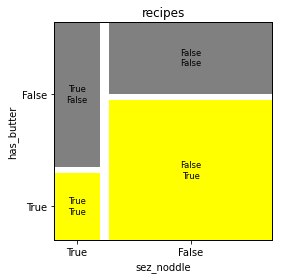

In [13]:
from collections import Counter
from matplotlib import pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# warning: `mosaic` expects data in (x_axis, y_axis), so revert
# the axis so that this contingency table has the same order
contingency_table = dict(Counter(tally))

fig, ax = plt.subplots(1, 1)

fig, _ = mosaic(
    contingency_table,
    index=[1, 0], 
    gap=0.05, 
    title="recipes",
    # improvde default cmap
    properties=lambda key: {"color": "yellow" if key[1] == "True" else "gray"},
    ax=ax,
)

ax.set_xlabel("sez_noddle")
ax.set_ylabel("has_butter")
ax.set_box_aspect(1)

Note the conditional probabilities in this sample:

  * `P(sez_noodle|has_butter)` at approximately 1:2
  * `P(has_butter|sez_noodle)` at approximately 1:4

The latter is significantly lower, so these conditions seem reasonably good to use as filters for identifying which recipes to annotate.
Of course, not every recipe is either a kind of pancake or noodle, since there are recipes for *omelette*, *Yorkshire pudding*, etc. 

We'll revisit this kind of problem later with more formal, semi-automated methods that leverage machine learning and *human-in-the-loop* approaches.

For now let's add annotations based on our manual review:

In [14]:
noodle_ids = { "400", "86710", "331765", "508734", "320154", "220361", "148900", "317697", "252783", "137357", "1975", "31041", "441475", "261361", "124106", "78459", "358908", "103964", "91311", "497918", "328388" }

In [15]:
pancake_ids = { "277824", "489", "4643", "272746", "12055", "124131", "40772", "459", "48178", "124176", "61108", "111008", "262038", "458", "440398", "157638" }

In [16]:
for id in noodle_ids:
    url = f"https://www.food.com/recipe/{id}"
    node = rdflib.URIRef(url)
    kg.add(node, kg.get_ns("rdf").type, kg.get_ns("nom").Noodle)

for id in pancake_ids:
    url = f"https://www.food.com/recipe/{id}"
    node = rdflib.URIRef(url)
    kg.add(node, kg.get_ns("rdf").type, kg.get_ns("nom").Pancake)

kg.save_rdf("tmp.ttl")

Now open the `tmp.ttl` file.
Notice the new annotations for `nom:Noodle` and `nom:Pancake` added to the recipes?

---

## Exercises

**Exercise 1:**

A third category of recipes that use *flour*, *eggs*, *salt* among their ingredients would be 
[*popovers*](https://en.wikipedia.org/wiki/Popover) (US usage) which are much the same as [*Yorkshire pudding*](https://en.wikipedia.org/wiki/Yorkshire_pudding) (UK usage).

Extend the `nom.ttl` vocabulary to include the definition of a `popover`

**Exercise 2:**

Revise the queries and post-processing above to identifier popover recipes.

**Exercise 3:**

Construct a `popover_ids` list for the identified recipes.

**Exercise 4:**
    
Annotate the KG to include `nom:popover` definitions for popovers.